In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np

import  matplotlib.pyplot as plt
import pickle

from chemistry import Molecule
from util import score
from pprint import pprint


In [3]:
with open('../data/molecules_enh.pickle', 'rb') as f:
    molecules = pickle.load(f)

m = molecules['dsgdb9nsd_000002']
m.compute_path(2, 3)
m

m = molecules['dsgdb9nsd_000014']
i0, i1 = 2, 3
p0, p1 = m.positions[i0], m.positions[i1]
mid = (p0 + p1) * 0.5
other_atoms = list(range(m.n_atoms))
other_atoms.remove(i0)
other_atoms.remove(i1)
p = m.positions[other_atoms]
diff = p - mid
dist = np.linalg.norm(diff, axis=1)
print(dist)
print(dist.argsort()[0:2])
print(dist[dist.argsort()[0:2]])

In [4]:
structures = pd.read_feather('../data/structures_enh.feather')
molecules_df = pd.read_feather('../data/molecules.feather')
labelled = pd.read_feather('../data/train.feather')
unlabelled = pd.read_feather('../data/test.feather')

In [5]:
labelled_enh = labelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
#labelled_enh.head(32)

In [6]:
unlabelled_enh = unlabelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
#unlabelled_enh.head(32)

In [ ]:
len(labelled), len(labelled_enh)

In [ ]:
from models import SKModel, partition_data

data_df = labelled[labelled.type == '1JHC'].head(10000)
#data_df = labelled_enh.head(16)
train_df, valid_df, test_df = partition_data(data_df, train_frac=1)
train_df = train_df#.copy()
        
model = SKModel(dict(molecules=molecules,
                     structures=structures), fit_args={})
input_df, numeric_df, output_df = model.setup_data(train_df, train_df)
None

In [ ]:
numeric_df.dtypes

In [ ]:
model.structures.columns

In [ ]:
list(input_df.columns)

In [ ]:
labelled['type'].unique()

In [ ]:
list(numeric_df.columns)

In [ ]:
unlabelled_enh['type'].iloc[0]

In [ ]:
columns = list(filter(lambda c: c.startswith('sergii') and (c.find('cos') != -1 or c.find('sin') != -1), numeric_df.columns))

In [ ]:
list(zip(input_df.columns, input_df.loc[14], input_df.loc[15]))

In [ ]:
import itertools

In [7]:
lgb_model_args = dict(n_jobs=8,
                      max_depth=16,
                      boosting_type='gbdt',
                      num_leaves=16384, #65536, #128,
                      min_child_samples=20,
                      min_data_in_leaf=100,
                      learning_rate=0.1,
                      n_estimators=2000,
                      reg_alpha=0.1,
                      reg_lambda=0.3,
                      bagging_fraction = 0.9,
                      bagging_freq = 5,
                      #num_iterations=200
                      )
lgb_fit_args = dict(early_stopping_rounds=100, verbose=100)

Training 50000 samples for 3JHH
  Setting up data
  Fitting model
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.17936
[200]	valid_0's l2: 0.15331
[300]	valid_0's l2: 0.140212
[400]	valid_0's l2: 0.133049
[500]	valid_0's l2: 0.12839
[600]	valid_0's l2: 0.125017
[700]	valid_0's l2: 0.12261
[800]	valid_0's l2: 0.120838
[900]	valid_0's l2: 0.119571
[1000]	valid_0's l2: 0.118667
[1100]	valid_0's l2: 0.117881
[1200]	valid_0's l2: 0.117172
[1300]	valid_0's l2: 0.116761
[1400]	valid_0's l2: 0.11632
[1500]	valid_0's l2: 0.115984
[1600]	valid_0's l2: 0.115722
[1700]	valid_0's l2: 0.115476
[1800]	valid_0's l2: 0.115265
[1900]	valid_0's l2: 0.11507
[2000]	valid_0's l2: 0.114926
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l2: 0.114926
  Setting up data
  Fitting model
  Evaluating model
3JHH score: -1.604093571264467 (trained on 50000 elements)


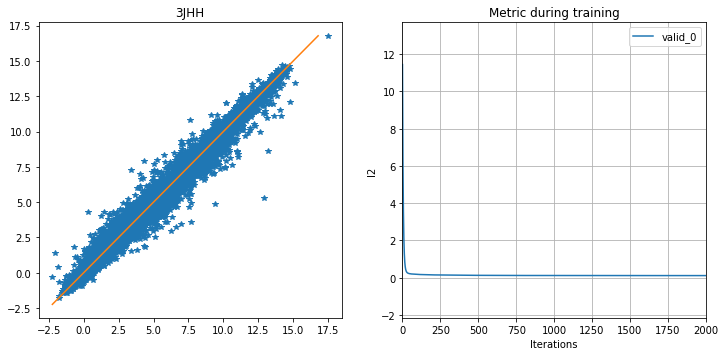

In [8]:
from models import LGBModel
from models import partition_data

#coupling_types = sorted(labelled_enh.type.unique())
coupling_types = ['3JHH']
models = {}
def run_test(data, count=None):
    global model
    
    plt.figure(figsize=(25, 25))
    for i, t in enumerate(coupling_types, 1):    
        data_df = data[data.type == t]
        if count is not None:
            data_df = data_df.head(count)

        train_df, valid_df, test_df = partition_data(data_df)
        
        if len(train_df) < 10 or len(test_df) < 10:
            continue
            
        print(f'Training {len(train_df)} samples for {t}')

        model = LGBModel(dict(molecules=molecules, 
                              structures=structures,
                              verbose=True),
                         lgb_model_args, lgb_fit_args)
        models[t] = model

        model.fit(train_df, train_df, valid_df, valid_df)
        output, score = model.evaluate(test_df, test_df)
        
        print(f'{t} score: {score} (trained on {len(train_df)} elements)')
        plt.subplot(4, 4, 2 * i - 1)
        plt.plot(test_df.scalar_coupling_constant, output, '*')
        mn = min(test_df.scalar_coupling_constant.min(), output.min())
        mx = min(test_df.scalar_coupling_constant.max(), output.max())
        plt.plot([mn, mx], [mn, mx])
        plt.title(t)
        
        ax = plt.subplot(4, 4, 2 * i)
        model.plot_metric(ax=ax)
    plt.show()
        
run_test(labelled_enh, 100000)


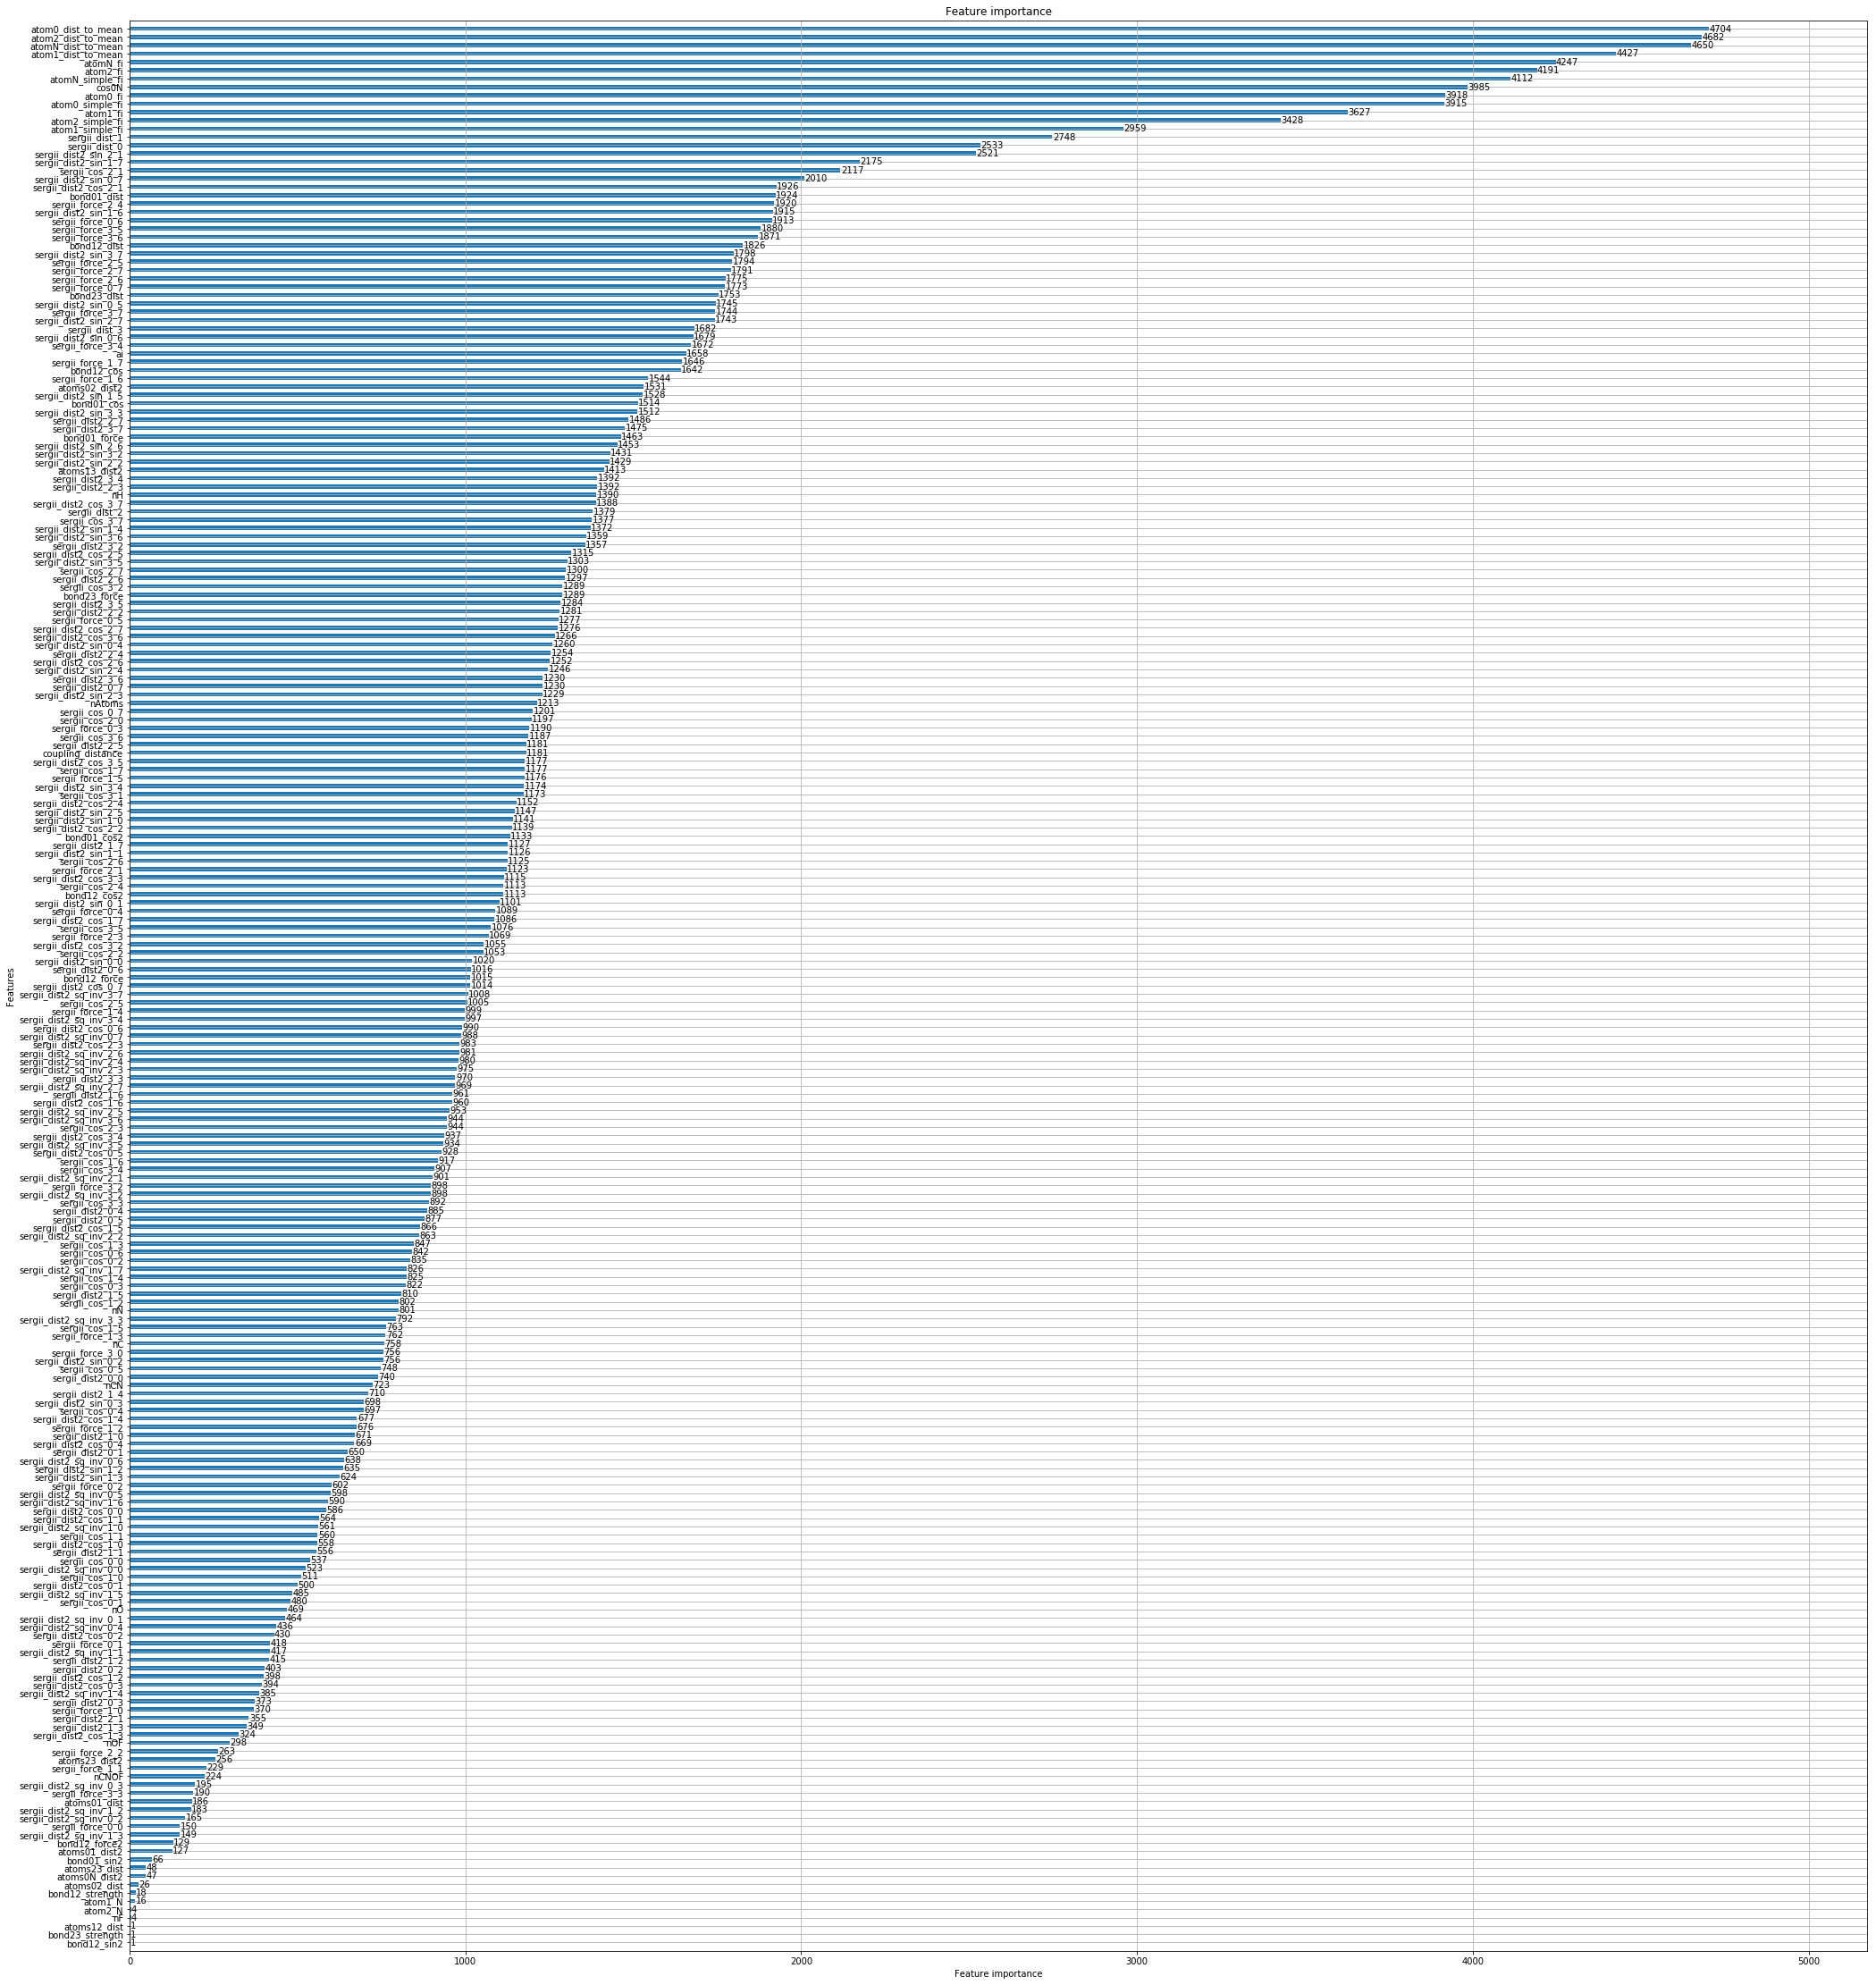

In [9]:
from models import LGBModel
fig = plt.figure(figsize=(27, 30))
model.plot_importance(ax=fig.add_axes([0, 0, 1, 1]), height=0.5)
plt.show()

In [ ]:
model.last_numeric_input_df.loc[:, ['bond12_cos']].head()

In [ ]:
list(model.last_numeric_input_df.columns)

In [10]:
lgb_model_args = dict(n_jobs=8,
                      max_depth=16,
                      boosting_type='gbdt',
                      num_leaves=16384, #65536, #128,
                      min_child_samples=20,
                      min_data_in_leaf=100,
                      learning_rate=0.1,
                      n_estimators=2000,
                      reg_alpha=0.1,
                      reg_lambda=0.3,
                      bagging_fraction = 0.9,
                      bagging_freq = 5,
                      #num_iterations=200
                      )
lgb_fit_args = dict(verbose=100)

In [11]:
from models import LGBModel

def train(data):
    models = {}
    for t in sorted(data.type.unique()):
        train_df = data[data.type == t]
        print(f'Training {len(train_df)} samples for {t}')
        model = LGBModel(dict(molecules=molecules, 
                              structures=structures),
                         lgb_model_args, lgb_fit_args)
        models[t] = model
        model.fit(train_df, train_df)
    
    return models

#models = train(labelled_enh.head(200))
models = train(labelled_enh)

Training 709416 samples for 1JHC
Training 43363 samples for 1JHN
Training 1140674 samples for 2JHC
Training 378036 samples for 2JHH
Training 119253 samples for 2JHN
Training 1510379 samples for 3JHC
[12, 2, 7] 12 7 
 dsgdb9nsd_133831
[17, 7, 2] 17 2 
 dsgdb9nsd_133831
Training 590611 samples for 3JHH
Training 166415 samples for 3JHN


In [12]:
def predict(data, models):
    out_df = None
    
    for t in sorted(data.type.unique()):
        predict_df = data[data.type == t]
        print(f'Predicting {len(predict_df)} samples for {t}')
        output = models[t].predict(predict_df)
        
        id = predict_df['id']
        out_df_coupling = pd.DataFrame(data={'id':id, 'scalar_coupling_constant':output}, index=predict_df.index)
        
        if out_df is None:
            out_df = out_df_coupling
        else:
            out_df = out_df.append(out_df_coupling).sort_index()

    return out_df.sort_index()
    
#prediction = predict(unlabelled_enh.head(200), models)
prediction = predict(unlabelled_enh, models)

Predicting 380609 samples for 1JHC
Predicting 24195 samples for 1JHN
Predicting 613138 samples for 2JHC
[13, 4, 3, 0, 1, 8] 13 8 
 dsgdb9nsd_037497
[17, 8, 1, 0, 3, 4] 17 4 
 dsgdb9nsd_037497
[12, 6, 7, 1] 12 1 
 dsgdb9nsd_072320
[14, 3, 2, 1, 8] 14 8 
 dsgdb9nsd_133863
[20, 7, 0, 1, 8] 20 8 
 dsgdb9nsd_133863
Predicting 203126 samples for 2JHH
Predicting 64424 samples for 2JHN
Predicting 811999 samples for 3JHC
[11, 1, 0, 3, 4] 11 4 
 dsgdb9nsd_037497
[13, 4, 3, 0, 1] 13 1 
 dsgdb9nsd_037497
[13, 4, 5, 6, 7] 13 7 
 dsgdb9nsd_037497
[14, 5, 6, 7, 8] 14 8 
 dsgdb9nsd_037497
[15, 5, 6, 7, 8] 15 8 
 dsgdb9nsd_037497
[16, 7, 6, 5, 4] 16 4 
 dsgdb9nsd_037497
[17, 8, 7, 6, 5] 17 5 
 dsgdb9nsd_037497
[9, 0, 1, 7, 6] 9 6 
 dsgdb9nsd_072320
[10, 2, 1, 7, 6] 10 6 
 dsgdb9nsd_072320
[11, 2, 1, 7, 6] 11 6 
 dsgdb9nsd_072320
[12, 6, 7, 1, 2] 12 2 
 dsgdb9nsd_072320
[14, 3, 2, 1, 0, 7] 14 7 
 dsgdb9nsd_133863
[20, 7, 0, 1, 2, 3] 20 3 
 dsgdb9nsd_133863
Predicting 317435 samples for 3JHH
[13, 4, 3, 0

In [13]:
prediction.head()

,id,scalar_coupling_constant
0,4658147,21.958142
1,4658148,178.538510
2,4658149,13.271453
3,4658150,139.499197
4,4658151,21.576663


In [14]:
prediction.to_csv('../data/pred.csv',index=False)